In [1]:
import os
import numpy as np
import yaml
import pandas as pd
import textwrap

Simple Functions

In [2]:
def get_yaml_data_from_arxiv_number(arxiv_number):
    with open(os.path.join('..', f'{arxiv_number}', f'{arxiv_number}.yaml'), 'r') as f:
        return yaml.safe_load(f)

In [3]:
with open('../prompt_classification.yaml', 'r') as f:
    prompt_classification = yaml.safe_load(f)

In [4]:
with open('../Task_type.yaml', 'r') as f:
    task_type = yaml.safe_load(f)

In [5]:
is_ambigous_dict = {}
for task in prompt_classification:
    if task['task'] not in is_ambigous_dict:
        if 'placeholder' in task:
            is_ambigous_dict[task['task']] = [key for key,val in task['placeholder'].items() if val == 'A']

# Dataset

In [6]:
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]


def get_branch_from_arxiv_number(arxiv_number):
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number=arxiv_number)
    return yaml_data[0]["branch"]


# Keeps the pd.Series nicely ordered from the start
arxiv_number_list.sort(key=get_branch_from_arxiv_number)

# Construct List of Tuple Indices and Data

In [7]:
tuple_index_list = []
score_list = []

for arxiv_number in arxiv_number_list:
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number)

    # Branch name
    cur_branch_name = yaml_data[0]["branch"]

    # Arxiv number
    cur_arxiv_number = arxiv_number

    for task_dict in yaml_data[1:]:
        # Task name
        cur_task_name = task_dict["task"]
        cur_task_type=task_type[cur_task_name]

        for placeholder_name, placeholder_data in task_dict["placeholder"].items():
            # Placeholder name
            cur_placeholder_name = placeholder_name
            is_ambiguous = cur_placeholder_name in is_ambigous_dict.get(cur_task_name, [])

            if "score" in placeholder_data:  # Some entries in tasks don't have a score
                for scorer, score in placeholder_data["score"].items():
                    if scorer in ["Haining","Yasaman"]:
                        cur_scorer = scorer

                        tuple_index_list.append(
                            (
                                cur_branch_name,
                                cur_arxiv_number,
                                cur_task_name,
                                cur_task_type,
                                cur_placeholder_name,
                                is_ambiguous,
                                cur_scorer,
                            )
                        )
                    
                        if score is None:
                            cur_score = '(TODO)'
                            print((cur_arxiv_number,cur_task_name,cur_placeholder_name,cur_scorer))
                        else:
                            cur_score = score
                        score_list.append(cur_score)

('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'system', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'real|momentum', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'single-particle|second-quantized', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'degrees_of_freedom', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'site i and site j with the amplitude hopping', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'kinetic_symbol', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'definition_of_variables', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'You should ensure the hermiticity of the Hamiltonian', 'Yasaman')
('1106.6060', 'Construct interaction Hamiltonian (real space, lattice version)', 'second_int_symbol', 'Yasaman')
('1106.6060', 'Construct interaction Hamilton

# Create Pandas Series using MultiIndex

In [8]:
index = pd.MultiIndex.from_tuples(tuple_index_list, names=['branch', 'arxiv', 'task','task_type','placeholder', 'is_ambiguous','scorer',])
data = pd.DataFrame({'Score': score_list}, index=index)
data['Score']=pd.to_numeric(data['Score'],errors='coerce')

In [9]:
def remove(df,level='task', tasks_to_exclude=["Combine the Hartree and Fock term", ]):
    mask = df.index.get_level_values('task').isin(tasks_to_exclude)
    rows_to_keep = ~mask
    df_filtered = df[rows_to_keep]
    df_dropped = df.drop(labels=tasks_to_exclude, level=level)
    return df_dropped


In [10]:
data = remove(data)

In [433]:
# data.to_pickle('reading_data.pickle')

In [11]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Average score')

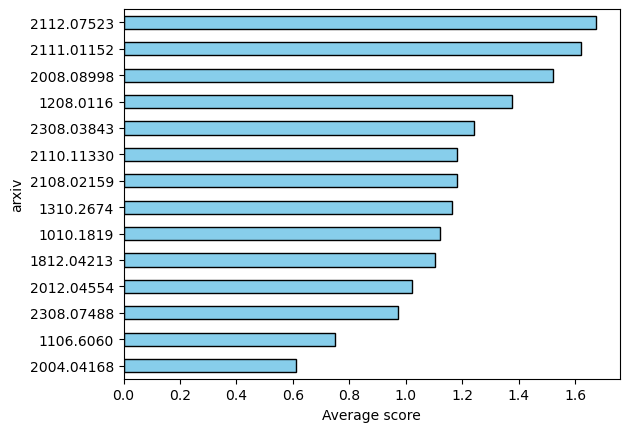

In [12]:
data_value_sort=data.xs(key='Haining',level='scorer').groupby('arxiv').mean().sort_values(by='Score')
data_value_sort.plot(kind='barh',color='skyblue',edgecolor='k',legend=False)
plt.xlabel('Average score')

# Compare different tasks

In [14]:
reading_literally=["definition_of_variables",'degrees_of_freedom','diagonal_potential','offdiagonal_potential','normalization_factor','int_form','interaction','interaction_degrees_of_freedom','parabolic|Dirac|cos','site i and site j with the amplitude hopping','site i and site j with the interaction strength','system']
reading_with_inferring=["$r$|$k$","Energy_dispersion","For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$","Ham_op","Note that hopping have no position dependence now.",'Note that interaction have no position dependence now','Note that the sublattice degrees of freedom is suppressed for now and will be stated later','Potential_variables','Unsummed_Indices','You should ensure the hermiticity of the Hamiltonian','electrons|holes','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone','real|momentum','single-particle|second-quantized']
background_knowledge=['annihilation_op','bilinear_op','creation_op','definition_of_Fourier_Transformation','hole_annihilation_op','hole_creation_op','hole_op','particle_op','momentum_creation_op','real_creation_op','particle_annihilation_op','particle_creation_op',]
symbols=['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'dispersion_symbol',
 'density_symbol']

In [15]:
len(set(symbols))-len(symbols)

0

In [16]:
occurrence=data.index.get_level_values('placeholder').value_counts().to_dict()

In [17]:
reading_literally_sorted=sorted(reading_literally,key=occurrence.get,reverse=True)
for key in reading_literally_sorted:
    print(f'{key}:{occurrence[key]}')
reading_literally_compare_list=reading_literally_sorted

definition_of_variables:180
degrees_of_freedom:42
system:28
normalization_factor:14
int_form:14
interaction:14
parabolic|Dirac|cos:14
site i and site j with the amplitude hopping:14
site i and site j with the interaction strength:14
diagonal_potential:8
offdiagonal_potential:8
interaction_degrees_of_freedom:8


In [18]:
reading_with_inferring_sorted=sorted(reading_with_inferring,key=occurrence.get,reverse=True)
for key in reading_with_inferring_sorted:
    print(f'{key}:{occurrence[key]}')
reading_with_inferring_compare_list=['single-particle|second-quantized','real|momentum','Energy_dispersion','electrons|holes','Unsummed_Indices','$r$|$k$','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone']

single-particle|second-quantized:50
real|momentum:44
Energy_dispersion:14
For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$:14
Note that hopping have no position dependence now.:14
Note that interaction have no position dependence now:14
You should ensure the hermiticity of the Hamiltonian:14
electrons|holes:14
Unsummed_Indices:12
Note that the sublattice degrees of freedom is suppressed for now and will be stated later:10
$r$|$k$:8
Potential_variables:8
entire_real|first_Brillouin_Zone:4
entire_space|first_Brillouin_zone:4
Ham_op:2


In [19]:
background_knowledge_sorted=sorted(background_knowledge,key=occurrence.get,reverse=True)
for key in background_knowledge_sorted:
    print(f'{key}:{occurrence[key]}')
background_knowledge_compare_list=background_knowledge_sorted[:4]

definition_of_Fourier_Transformation:32
momentum_creation_op:32
real_creation_op:32
bilinear_op:28
annihilation_op:4
creation_op:4
hole_op:4
hole_annihilation_op:2
hole_creation_op:2
particle_op:2
particle_annihilation_op:2
particle_creation_op:2


In [20]:
symbols_sorted=sorted(symbols,key=occurrence.get,reverse=True)
for key in symbols_sorted:
    print(f'{key}:{occurrence[key]}')
symbols_compare_list=symbols_sorted[:10]

Hartree_Fock_second_quantized_symbol:76
second_int_symbol:70
kinetic_symbol:64
Hartree_Fock_symbol:28
Hartree_Fock_term_symbol:28
potential_symbol:24
second_nonint_symbol:24
nonint_symbol:22
Hartree_second_quantized_symbol:18
k_symbol:14
r_symbol:14
In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.:14
Fock_second_quantized_symbol:14
density_symbol:14
matrix_element_symbol:8
basis_symbol:8
dispersion_symbol:4


In [21]:
symbols_compare_list

['Hartree_Fock_second_quantized_symbol',
 'second_int_symbol',
 'kinetic_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'nonint_symbol',
 'Hartree_second_quantized_symbol',
 'k_symbol']

In [22]:
compare_list=['real|momentum','single-particle|second-quantized','degrees_of_freedom','definition_of_variables','definition_of_Fourier_Transformation','system','parabolic|Dirac|cos',]

In [23]:
[index for index in data.index.get_level_values('placeholder').unique() if 'symbol' in index]

['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'dispersion_symbol',
 'density_symbol']

In [24]:
set(data.index.get_level_values('placeholder').unique())-set(symbols)

{'$r$|$k$',
 'Energy_dispersion',
 'For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$',
 'Ham_op',
 'Note that hopping have no position dependence now.',
 'Note that interaction have no position dependence now',
 'Note that the sublattice degrees of freedom is suppressed for now and will be stated later',
 'Potential_variables',
 'Unsummed_Indices',
 'You should ensure the hermiticity of the Hamiltonian',
 'annihilation_op',
 'bilinear_op',
 'creation_op',
 'definition_of_Fourier_Transformation',
 'definition_of_variables',
 'degrees_of_freedom',
 'diagonal_potential',
 'electrons|holes',
 'entire_real|first_Brillouin_Zone',
 'entire_space|first_Brillouin_zone',
 'expected_value',
 'expected_value_Hartree',
 'expected_value_nonzero',
 'expression_Hartree_1',
 'expression_Hartree_2',
 'expression_diag',
 'expression_offdiag',
 'hole_annihilation_op',
 'hole_creation_op',
 'hole_op',
 'index_1',
 'index_2',
 'index_

## Comparing results

### Reading ability

In [25]:
data_groupby=data.groupby('placeholder').agg(['mean','sem','count'])

In [26]:
data_groupby.loc[reading_literally_compare_list]

Score                
                                                     mean       sem count
placeholder                                                              
definition_of_variables                          1.634286  0.050804   175
degrees_of_freedom                               1.525000  0.113157    40
system                                           1.740741  0.126227    27
normalization_factor                             1.214286  0.260569    14
int_form                                         1.285714  0.244243    14
interaction                                      1.071429  0.266526    14
parabolic|Dirac|cos                              1.428571  0.250588    14
site i and site j with the amplitude hopping     1.538462  0.243252    13
site i and site j with the interaction strength  1.769231  0.121626    13
diagonal_potential                               0.500000  0.327327     8
offdiagonal_potential                            1.750000  0.250000     8
interaction_degrees_of_freedom                   0.500000  0.267261     8

In [27]:
def plot_bar(compare_list,df_groupby,title,width=25):
    ax=df_groupby.loc[compare_list]['Score']['mean'].sort_values().plot(kind='barh',color='skyblue',edgecolor='k',xerr=df_groupby.loc[compare_list]['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
    ax.grid(axis='x',ls='--')
    ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=width)) for task in df_groupby.loc[compare_list]['Score']['mean'].sort_values().index],fontsize=7)
    ax.set_ylabel('')
    ax.set_xlabel('Score')
    ax.set_title(f'{title} (mean={df_groupby.loc[compare_list]["Score"]["mean"].mean():.2f})')

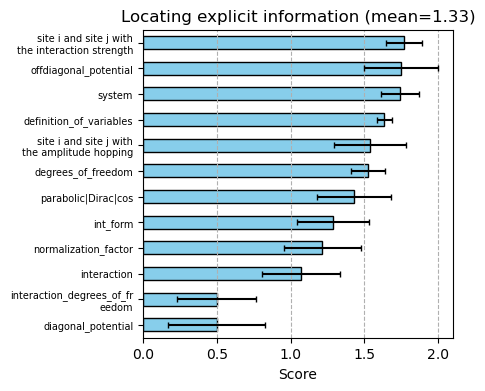

In [29]:
plot_bar(reading_literally_compare_list, data_groupby, 'Locating explicit information')

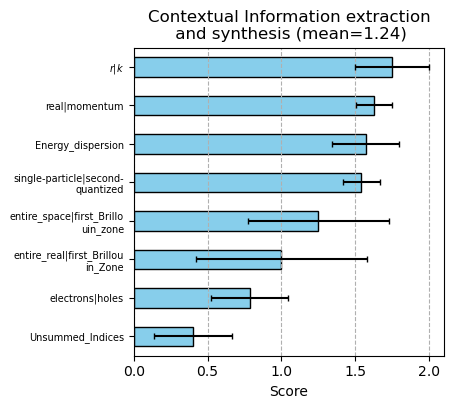

In [31]:
plot_bar(reading_with_inferring_compare_list, data_groupby, 'Contextual Information extraction\n and synthesis')

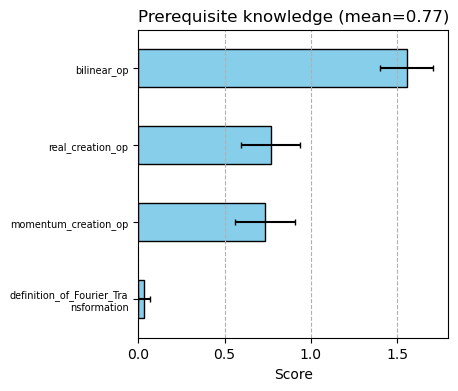

In [32]:
plot_bar(background_knowledge_compare_list, data_groupby, 'Prerequisite knowledge')

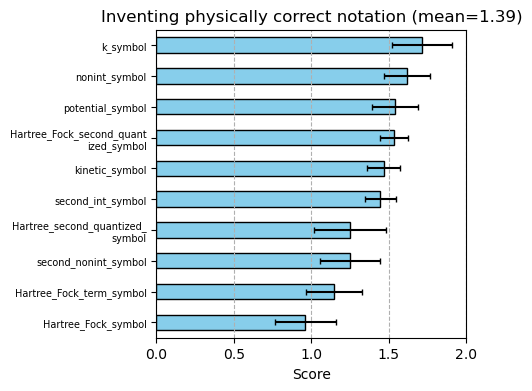

In [35]:
plot_bar(symbols_compare_list, data_groupby, 'Inventing physically correct notation')

# Score by task

In [36]:
with open('../Naming.yaml','r') as f:
    naming=yaml.safe_load(f)

In [37]:
data_groupby_task=data.groupby('task').agg(['mean','sem','count'])


In [38]:
data_groupby_task_common=data_groupby_task[data_groupby_task['Score']['count']>=28].sort_values(by=('Score','mean'),)


Text(0.5, 1.0, 'Score of information extraction by tasks')

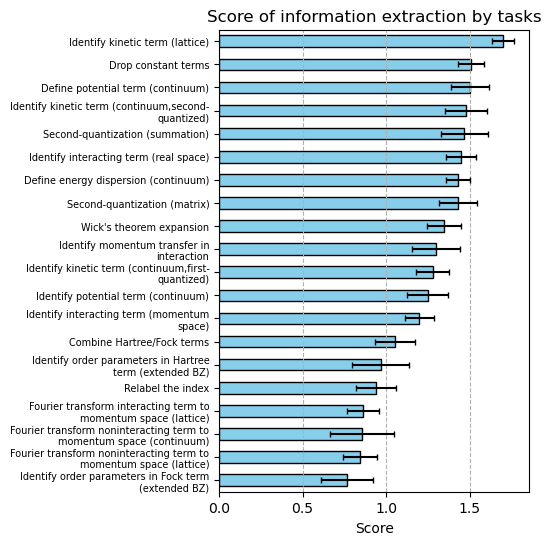

In [50]:
ax=data_groupby_task_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_task_common['Score']['sem'],legend=False,figsize=(4, 6),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(naming[task], width=40)) for task in data_groupby_task_common['Score']['mean'].index],fontsize=7)
ax.set_title('Score of information extraction by tasks')

# Score by task type

In [40]:
task_type_order=['Hamiltonian of QMB problem','Hamiltonian in momentum space','Mean field decomposition','Hartree and Fock terms','Order parameter']

In [41]:
data_groupby_task_type=data.groupby('task_type').agg(['mean','sem','count'])
data_groupby_task_type=data_groupby_task_type.loc[task_type_order[::-1]]

In [42]:
data_groupby_task_type_common=data_groupby_task_type[data_groupby_task_type['Score']['count']>=28]

Text(0.5, 1.0, 'Scores of information extraction by steps')

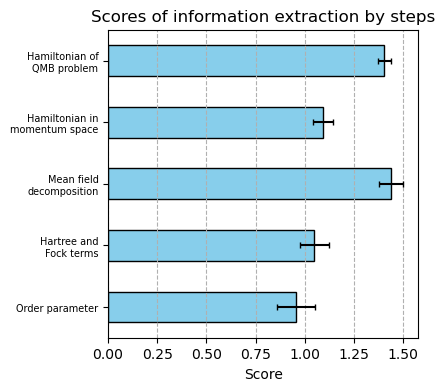

In [44]:
ax=data_groupby_task_type_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_task_type_common['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=15)) for task in data_groupby_task_type_common['Score']['mean'].index],fontsize=7)
ax.set_title('Scores of information extraction by steps')

# Score by branch

In [47]:
data_groupby_branch=data.groupby('branch').agg(['mean','sem','count'])

Text(0.5, 1.0, 'Score of information extraction by branches')

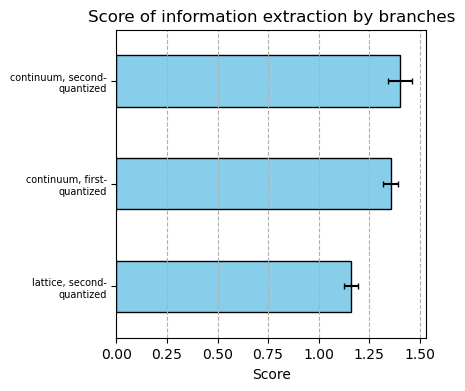

In [51]:
ax=data_groupby_branch['Score']['mean'].sort_values().plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_branch['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in data_groupby_branch['Score']['mean'].sort_values().index],fontsize=7)
ax.set_title('Score of information extraction by branches')

# Score by ambiguity

In [45]:
data_groupby_ambi=data.groupby('is_ambiguous').agg(['mean','sem','count'])

In [46]:
data_am_groupby_ph=data.xs(key=True,level='is_ambiguous').groupby('placeholder').agg(['mean','sem','count'])
data_unam_groupby_ph=data.xs(key=False,level='is_ambiguous').groupby('placeholder').agg(['mean','sem','count'])
data_am_group_ph_common=data_am_groupby_ph[data_am_groupby_ph['Score']['count']>=10].sort_values(by=('Score','mean'))
data_unam_group_ph_common=data_unam_groupby_ph[data_unam_groupby_ph['Score']['count']>=10].sort_values(by=('Score','mean'))

Text(0.5, 1.0, 'Ambiguous (mean=1.19$\\pm$0.21)')

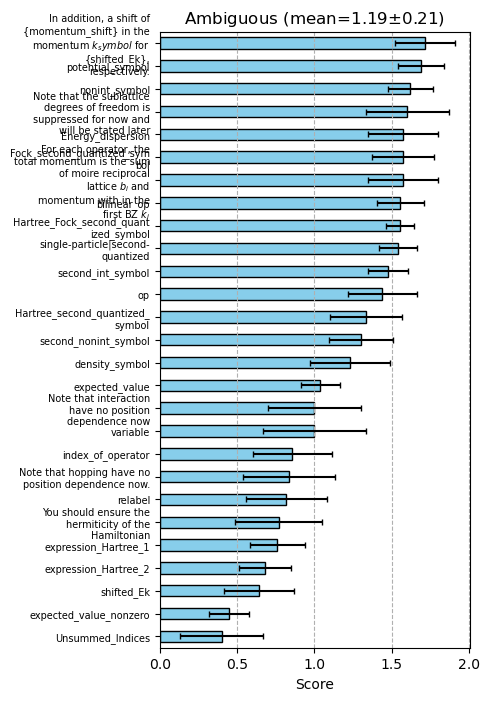

In [52]:
ax=data_am_group_ph_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_am_group_ph_common['Score']['sem'],legend=False,figsize=(4, 8),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=25)) for task in data_am_group_ph_common['Score']['mean'].index],fontsize=7)
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_title(f'Ambiguous (mean={data_am_group_ph_common["Score"]["mean"].mean():.2f}$\pm${data_am_group_ph_common["Score"]["sem"].mean():.2f})')

Text(0.5, 1.0, 'Unambiguous (mean=1.22$\\pm$0.18)')

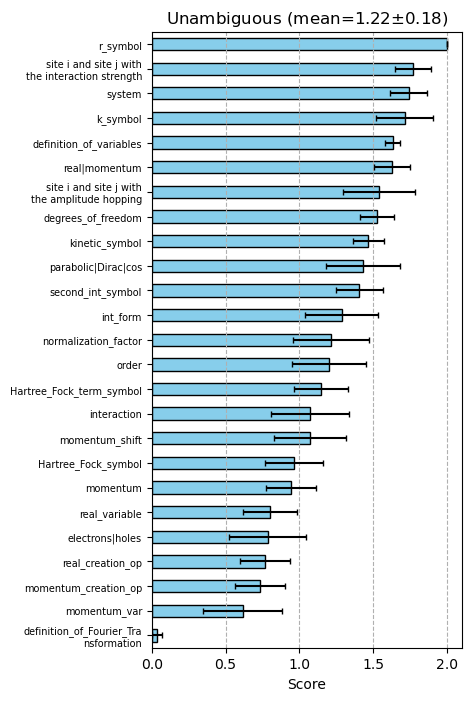

In [53]:
ax=data_unam_group_ph_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_unam_group_ph_common['Score']['sem'],legend=False,figsize=(4, 8),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=25)) for task in data_unam_group_ph_common['Score']['mean'].index],fontsize=7)
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_title(f'Unambiguous (mean={data_unam_group_ph_common["Score"]["mean"].mean():.2f}$\pm${data_unam_group_ph_common["Score"]["sem"].mean():.2f})')